# Análisis orbital con Skyfield
Este notebook calcula la posición de un satélite a partir de su TLE

Importación de librerías

In [1]:
from skyfield.api import EarthSatellite, load
import matplotlib.pyplot as plt
import requests

Descargar el archivo de TLE correspondiente a ASTROCAST-0401

In [2]:
url = "https://celestrak.org/NORAD/elements/gp.php?INTDES=2023-001"
response = requests.get(url)
tle_text = response.text #Se extrae el contenido de la respuesta como un archivo de texto, no binario

Buscar las líneas del satélite ASTROCAST-0401

In [3]:
nombre = 'ASTROCAST-0401'
lines = tle_text.strip().splitlines() #strip() elimina espacios en blanco al ppio y final del texto y .splitlines() divide el texto en una lista de líneas
# Buscar por coincidencia parcial e insensible a mayúsculas
linea_encontrada = None

for i, line in enumerate(lines):
    if nombre.lower() in line.lower():
        linea_encontrada = line.strip()
        line1 = lines[i + 1].strip()
        line2 = lines[i + 2].strip()
        break

    if linea_encontrada:
        print(f"Nombre exacto encontrado: {linea_encontrada}")
        print(line1)
        print(line2)
else:
    raise ValueError(f"No se encontró el satélite {nombre} en el archivo TLE descargado")
print(line1)
print(line2)

1 55110U 23001DF  25203.50329886  .00006000  00000+0  26799-3 0  9992
2 55110  97.5749 288.2693 0007626 286.1944  73.8452 15.21711028140965


Crear el objeto satélite

In [4]:
ts = load.timescale() #Carga la escala temporal
sat = EarthSatellite(line1,line2,nombre,ts) #Crear objeto satélite a partir de las líneas TLE
t = ts.now() #obtener tiempo actual en UTC

geocentric = sat.at(t) #Calcula la posición del satélite en ese instante
print(geocentric.xyz.km)

subpoint = geocentric.subpoint() #Obtener la proyección del satélite sobre la superficie terrestre
print(subpoint)

lat = subpoint.latitude.degrees
lon = subpoint.longitude.degrees
alt = subpoint.elevation.km

print(f"Satélite: {nombre}")
print(f"Latitud:  {lat:.2f}°")
print(f"Longitud: {lon:.2f}°")
print(f"Altura:   {alt:.2f} km")

[ 2110.21381069 -4356.8317996  -4890.13361443]
IERS2010 latitude -45.4069 N longitude 58.9447 E elevation 513682.3 m
Satélite: ASTROCAST-0401
Latitud:  -45.41°
Longitud: 58.94°
Altura:   513.68 km


Representación Mapa 2D

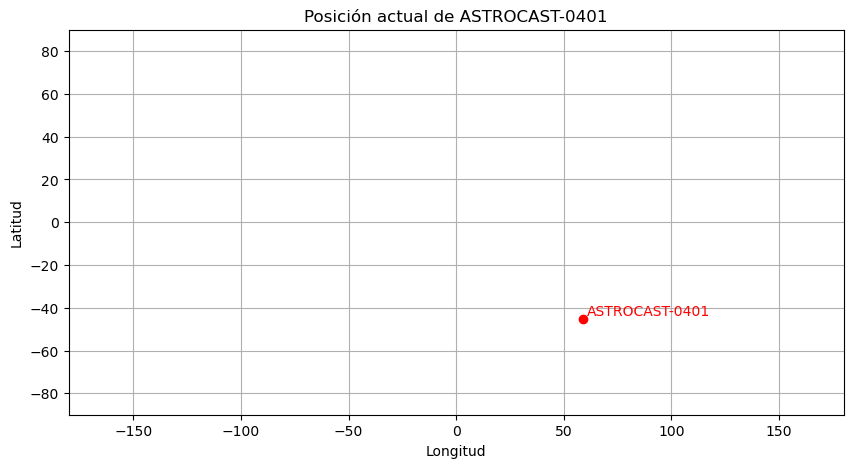

In [5]:
# Crear una figura con tamaño adecuado
plt.figure(figsize=(10, 5))

# Dibujar un mapa base simple (límites de lat/lon de la Tierra)
plt.xlim(-180, 180)  # Longitud
plt.ylim(-90, 90)    # Latitud

# Añadir líneas de rejilla
plt.grid(True)

# Etiquetas de ejes
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title(f"Posición actual de {nombre}")

# Dibujar el punto del satélite
plt.plot(lon, lat, 'ro')  # 'ro' = red circle
plt.text(lon + 2, lat + 2, nombre, color='red')

# Mostrar el gráfico
plt.show()


Representar el mapa con costas reales

C:\Users\pablo\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\pablo\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


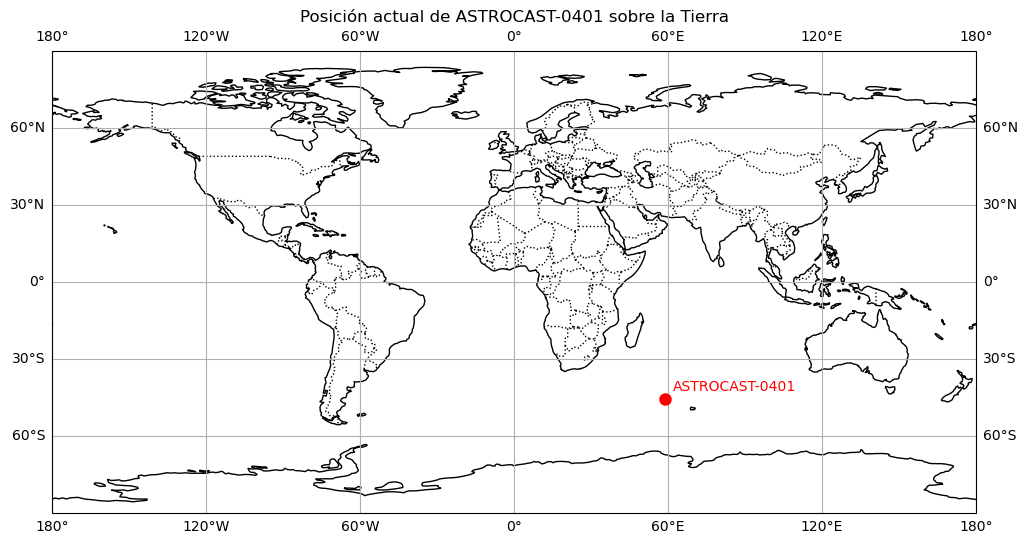

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Crear figura con proyección geográfica
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Añadir elementos al mapa
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# Dibujar la posición del satélite
ax.plot(lon, lat, 'ro', markersize=8, transform=ccrs.Geodetic())
ax.text(lon + 3, lat + 3, nombre, color='red', transform=ccrs.Geodetic())

# Título
plt.title(f"Posición actual de {nombre} sobre la Tierra")
plt.show()
